In [1]:
# This is a hidden cell which will be executed but will not show up in Sphinx docs.
# To hide a cell, in Jupyter go to Menu->View->Cell Toolbar->Edit Metadata
# and enter in {"nbsphinx": "hidden"}

# Set figure size and font size
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['font.size'] = 12

# Paths and waveguides

[PHIDL](https://github.com/amccaugh/phidl) includes an extremely efficient module for creating curves, particularly useful for creating waveguide structures such as those used in photonics. Creating a path device is simple:

- Create a blank `Path`
- Append points to the `Path` either using the built-in functions (`arc()`, `straight()`, `euler()`, etc) or by providing your own lists of points
- Specify what you want the cross-section (`CrossSection`) to look like
- Combine the `Path` and the `CrossSection` (will output a Device with the path polygons in it)

## Path creation

The first step is to generate the list of points we want the path to follow.  Let's start out by creating a blank `Path` and using the built-in functions to make a few smooth turns.

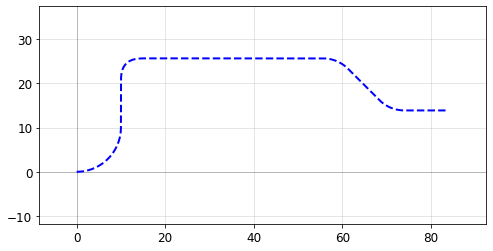

In [2]:
from phidl import Path, CrossSection, Device
import phidl.path as pp
import numpy as np

P = Path()
P.append( pp.arc(radius = 10, angle = 90) )   # Circular arc
P.append( pp.straight(length = 10) )          # Straight section
P.append( pp.euler(radius = 3, angle = -90) ) # Euler bend (aka "racetrack" curve)
P.append( pp.straight(length = 40) )
P.append( pp.arc(radius = 8, angle = -45) )
P.append( pp.straight(length = 10) )
P.append( pp.arc(radius = 8, angle = 45) )
P.append( pp.straight(length = 10) )

from phidl import quickplot as qp
qp(P)

We can also modify our Path in the same ways as any other PHIDL object:

- Manipulation with `move()`, `rotate()`, `mirror()`, etc
- Accessing properties like `xmin`, `y`, `center`, `bbox`, etc

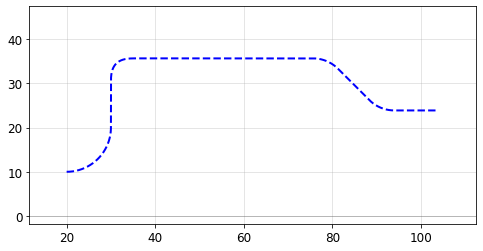

In [3]:
P.movey(10)
P.xmin = 20
qp(P)

We can also check the length of the curve with the `length()` method:

In [4]:
P.length()

107.69901058617913

## Defining the cross-section

Now that we've got our path defined, the next step is to tell phidl what we want the cross-section of the path to look like and then `extrude()` it.  There's a few different ways of doing this.

### Option 1: Fixed width cross-section

The simplest option is to just set the cross-section to be a constant width by passing a number to `extrude()` like so:

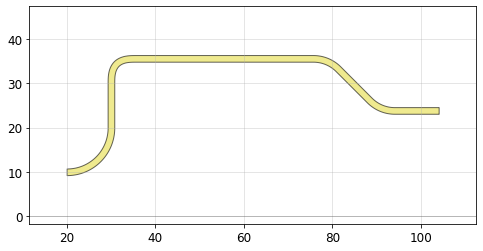

In [5]:
waveguide_device = P.extrude(1.5, layer = 3)
qp(waveguide_device)

### Option 2: Linearly-varying width

A slightly more advanced version is to make the cross-section width vary linearly from start to finish by passing a 2-element list to `extrude()` like so:

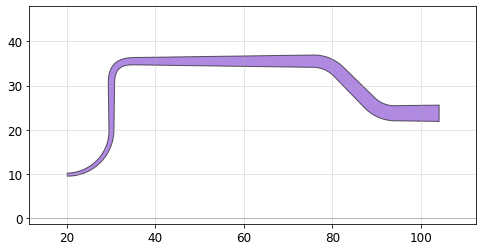

In [6]:
waveguide_device = P.extrude([0.7,3.7], layer = 4)
qp(waveguide_device)

### Option 3: Complex CrossSection objects

If we want a more complex cross-section we can create `CrossSection` object and add any number of cross-sectional elements to it.  We can then combine the `Path` and the `CrossSection` using the `extrude()` function to generate our final geometry.  

For instance, in some photonic applications it's helpful to have a shallow etch that appears on either side of the waveguide (often called a "sleeve").  Additionally, it might be nice to have a Port on either end of the center section so we can snap other geometries to it:

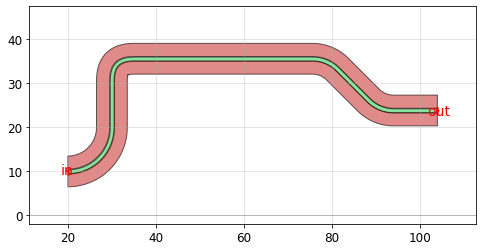

In [7]:
# Create a blank CrossSection
X = CrossSection()

# Add a a few "sections" to the cross-section
X.add(width = 1, offset = 0, layer = 0, ports = ('in','out'))
X.add(width = 3, offset = 2, layer = 2)
X.add(width = 3, offset = -2, layer = 2)

# Combine the Path and the CrossSection
waveguide_device = P.extrude(X)

# Quickplot the resulting Device
qp(waveguide_device)

## Assembling Paths quickly

You can pass `append()` lists of path segments.  This makes it easy to combine paths very quickly.  Below we show 3 examples using this functionality:  

**Example 1:** Assemble a complex path by making a list of Paths and passing it to `append()`

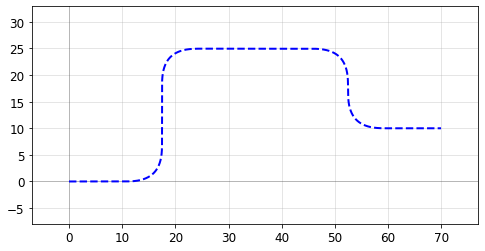

In [8]:
P = Path()

# Create the basic Path components
left_turn = pp.euler(radius = 4, angle = 90)
right_turn = pp.euler(radius = 4, angle = -90)
straight = pp.straight(length = 10)

# Assemble a complex path by making list of Paths and passing it to `append()`
P.append([
    straight,
    left_turn,
    straight,
    right_turn,
    straight,
    straight,
    right_turn,
    left_turn,
    straight,
])

qp(P)

**Example 2:** Create an "S-turn" just by making a list of `[left_turn, right_turn]`

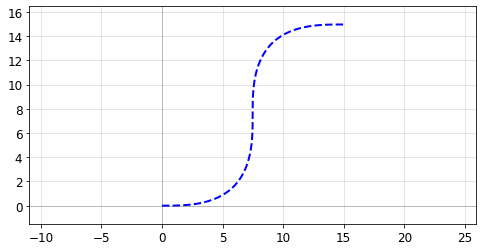

In [9]:
P = Path()

# Create an "S-turn" just by making a list
s_turn = [left_turn, right_turn]

P.append(s_turn)

qp(P)

**Example 3:** Repeat the S-turn 3 times by nesting our S-turn list in another list

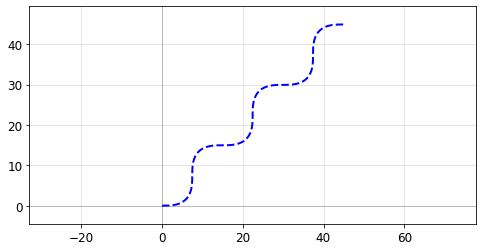

In [10]:
P = Path()

# Create an "S-turn" using a list
s_turn = [left_turn, right_turn]
# Repeat the S-turn 3 times by nesting our S-turn list 3x times in another list
triple_s_turn = [s_turn, s_turn, s_turn]

P.append(triple_s_turn)

qp(P)

Note you can also use the Path() constructor to immediately contruct your Path:

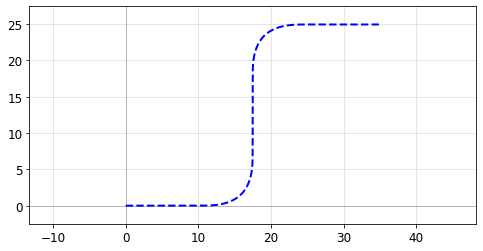

In [11]:
P = Path([straight, left_turn, straight, right_turn, straight])
qp(P)

## Waypoint-based smooth paths

We can also build smooth paths between waypoints using the `smooth()` function.  Let's say we wanted to route our path along the following points:

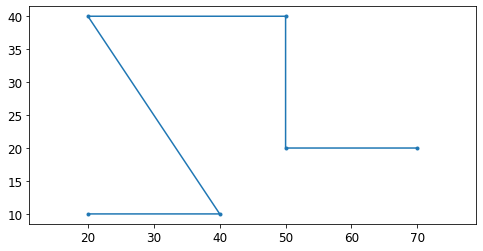

In [12]:
points = np.array([(20,10), (40,10), (20,40), (50,40), (50,20), (70,20)])
plt.plot(points[:,0], points[:,1], '.-')
plt.axis('equal');

We can use `smooth()` to generate a smoothed Path from these waypoints. You can specify the corner-rounding function with the `corner_fun` argument (typically using either `euler()` or `arc()`), and provide any additional parameters to the corner-rounding function. Note here we provide the the additional argument `use_eff = False` (which gets passed to `pp.euler` so that the minimum radius of curvature is 2).

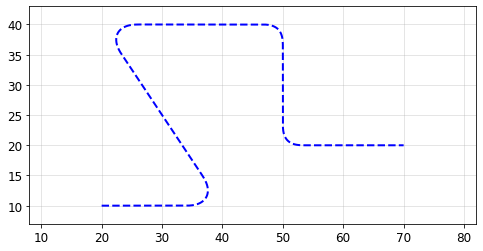

In [13]:
points = np.array([(20,10), (40,10), (20,40), (50,40), (50,20), (70,20)])

P = pp.smooth(
    points = points, 
    radius = 2,
    corner_fun = pp.euler, # Alternatively, use pp.arc
    use_eff = False,
    )
qp(P)

## Sharp/angular paths


It's also possible to make more traditional angular paths (e.g. electrical wires) in a few different ways.

**Example 1:** Using a simple list of points

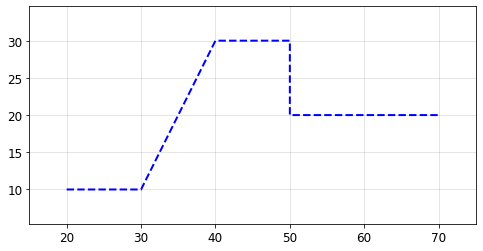

In [14]:
P = Path([(20,10), (30,10), (40,30), (50,30), (50,20), (70,20)])

qp(P)

**Example 2:** Using the "turn and move" method, where you manipulate the end angle of the Path so that when you append points to it, they're in the correct direction.  *Note: It is crucial that the number of points per straight section is set to 2 (`pp.straight(length, num_pts = 2)`) otherwise the extrusion algorithm will show defects.*

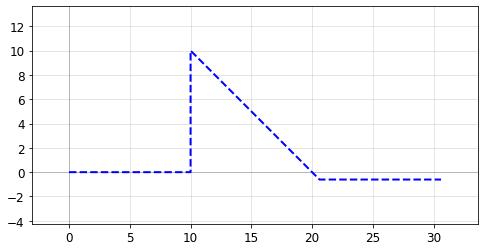

In [15]:
P = Path()
P.append( pp.straight(length = 10, num_pts = 2) )
P.end_angle += 90                    # "Turn" 90 deg (left)
P.append( pp.straight(length = 10, num_pts = 2) ) # "Walk" length of 10
P.end_angle += -135                  # "Turn" -135 degrees (right)
P.append( pp.straight(length = 15, num_pts = 2) ) # "Walk" length of 10
P.end_angle = 0                      # Force the direction to be 0 degrees
P.append( pp.straight(length = 10, num_pts = 2) ) # "Walk" length of 10
qp(P)

As usual, these paths can be used with a `CrossSection` to create nice extrusions:

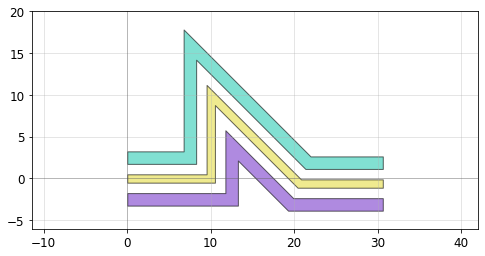

In [16]:
X = CrossSection()

X.add(width = 1, offset = 0, layer = 3)
X.add(width = 1.5, offset = 2.5, layer = 4)
X.add(width = 1.5, offset = -2.5, layer = 7)
wiring_device = P.extrude(X)

qp(wiring_device)

## Custom curves

Now let's have some fun and try to make a loop-de-loop structure with parallel waveguides and several Ports. 

To create a new type of curve we simply make a function that produces an array of points.  The best way to do that is to create a function which allows you to specify a large number of points along that curve -- in the case below, the `looploop()` function outputs 1000 points along a looping path.  Later, if we want reduce the number of points in our geometry we can trivially `simplify` the path.

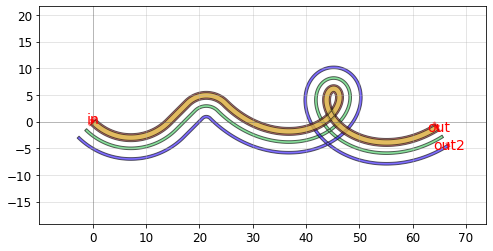

In [17]:
def looploop(num_pts = 1000):
    """ Simple limacon looping curve """
    t = np.linspace(-np.pi,0,num_pts)
    r = 20 + 25*np.sin(t)
    x = r*np.cos(t)
    y = r*np.sin(t)
    points = np.array((x,y)).T
    return points

# Create the path points
P = Path()
P.append( pp.arc(radius = 10, angle = 90) )
P.append( pp.straight())
P.append( pp.arc(radius = 5, angle = -90) )
P.append( looploop(num_pts = 1000) )
P.rotate(-45)

# Create the crosssection
X = CrossSection()
X.add(width = 0.5, offset = 2, layer = 0, ports = [None,None])
X.add(width = 0.5, offset = 4, layer = 1, ports = [None,'out2'])
X.add(width = 1.5, offset = 0, layer = 2, ports = ['in','out'])
X.add(width = 1, offset = 0, layer = 3)

D = P.extrude(X)
qp(D) # quickplot the resulting Device

You can create Paths from any array of points!  If we examine our path `P` we can see that all we've simply created a long list of points:

In [18]:
import numpy as np
path_points = P.points       # Curve points are stored as a numpy array in P.points
print(np.shape(path_points)) # The shape of the array is Nx2
print(len(P))                # Equivalently, use len(P) to see how many points are inside

(1457, 2)
1457


## Simplifying / reducing point usage

One of the chief concerns of generating smooth curves is that too many points are generated, inflating file sizes and making boolean operations computationally expensive.  Fortunately, PHIDL has a fast implementation of the [Ramer-Douglas–Peucker algorithm](https://en.wikipedia.org/wiki/Ramer%E2%80%93Douglas%E2%80%93Peucker_algorithm) that lets you reduce the number of points in a curve without changing its shape.  All that needs to be done is when you `extrude()` the device, you specify the `simplify` argument.

If we specify `simplify = 1e-3`, the number of points in the line drops from 12,000 to 4,000, and the remaining points form a line that is identical to within `1e-3` distance from the original (for the default 1 micron unit size, this corresponds to 1 nanometer resolution):

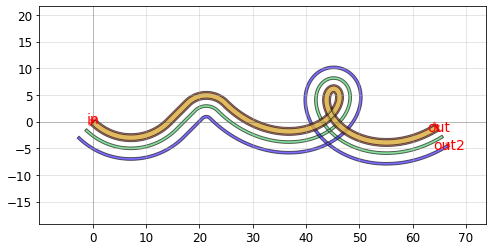

In [19]:
# The remaining points form a identical line to within `1e-3` from the original
D = P.extrude(X, simplify = 1e-3)
qp(D) # quickplot the resulting Device

Let's say we need fewer points.  We can increase the simplify tolerance by specifying `simplify = 1e-1`.  This drops the number of points to ~400 points form a line that is identical to within `1e-1` distance from the original:

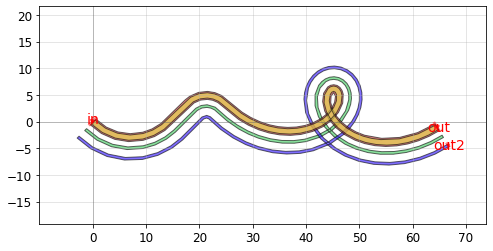

In [20]:
D = P.extrude(X, simplify = 1e-1)
qp(D) # quickplot the resulting Device

Taken to absurdity, what happens if we set `simplify = 0.3`?  Once again, the ~200 remaining points form a line that is within `0.3` units from the original -- but that line looks pretty bad.  

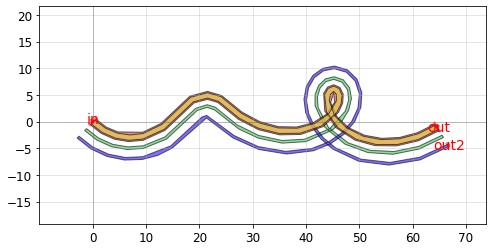

In [21]:
D = P.extrude(X, simplify = 0.3)
qp(D) # quickplot the resulting Device

## Curvature calculation

The `Path` class has a `curvature()` method that computes the curvature `K` of your smooth path (K = 1/(radius of curvature)).  This can be helpful for verifying that your curves transition smoothly such as in [track-transition curves](https://en.wikipedia.org/wiki/Track_transition_curve) (also known as "racetrack", "Euler", or "straight-to-bend" curves in the photonics world).  Note this curvature is numerically computed so areas where the curvature jumps instantaneously (such as between an arc and a straight segment) will be slightly interpolated, and sudden changes in point density along the curve can cause discontinuities.  It is recommended if using the curvature calculation with pp.straight to set `num_pts = 100` or more to avoid bad approximations

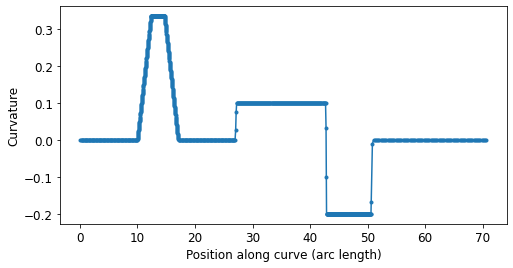

In [22]:
P = Path()
P.append([
    pp.straight(length = 10, num_pts = 100), # Curvature of 0
    # Euler straight-to-bend transition with min. bend radius of 3 (max curvature of 1/3)
    pp.euler(radius = 3, angle = 90, p = 0.5, use_eff = False),
    pp.straight(length = 10, num_pts = 100), # Curvature of 0
    pp.arc(radius = 10, angle = 90),         # Curvature of 1/10
    pp.arc(radius = 5, angle = -90),         # Curvature of -1/5
    pp.straight(length = 20, num_pts = 100), # Curvature of 0
    ])

s,K = P.curvature()
plt.plot(s,K,'.-')
plt.xlabel('Position along curve (arc length)')
plt.ylabel('Curvature');

## Transitioning between cross-sections

Often a critical element of building paths is being able to transition between cross-sections.  You can use the `transition()` function to do exactly this: you simply feed it two `CrossSection`s and it will output a new `CrossSection` that smoothly transitions between the two.

Let's start off by creating two cross-sections we want to transition between.  Note we give all the cross-sectional elements names by specifying the `name` argument in the `add()` function -- this is important because the transition function will try to match names between the two input cross-sections, and any names not present in both inputs will be skipped.

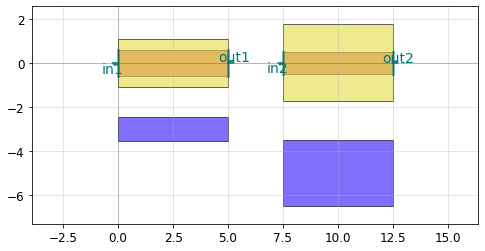

In [23]:
# Create our first CrossSection
X1 = CrossSection()
X1.add(width = 1.2, offset = 0, layer = 2, name = 'wg', ports = ('in1', 'out1'))
X1.add(width = 2.2, offset = 0, layer = 3, name = 'etch')
X1.add(width = 1.1, offset = 3, layer = 1, name = 'wg2')

# Create the second CrossSection that we want to transition to
X2 = CrossSection()
X2.add(width = 1, offset = 0, layer = 2, name = 'wg', ports = ('in2', 'out2'))
X2.add(width = 3.5, offset = 0, layer = 3, name = 'etch')
X2.add(width = 3, offset = 5, layer = 1, name = 'wg2')

# To show the cross-sections, let's create two Paths and 
# create Devices by extruding them
P1 = pp.straight(length = 5)
P2 = pp.straight(length = 5)
WG1 = P1.extrude(X1)
WG2 = P2.extrude(X2)

# Place both cross-section Devices and quickplot them
D = Device()
wg1 = D << WG1
wg2 = D << WG2
wg2.movex(7.5)

qp(D)

Now let's create the transitional CrossSection by calling `transition()` with these two CrossSections as input. If we want the width to vary as a smooth sinusoid between the sections, we can set `width_type` to `'sine'` (alternatively we could also use `'linear'`).

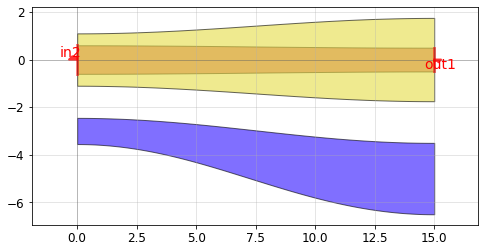

In [24]:
# Create the transitional CrossSection
Xtrans = pp.transition(cross_section1 = X1,
                       cross_section2 = X2,
                       width_type = 'sine')
# Create a Path for the transitional CrossSection to follow
P3 = pp.straight(length = 15)
# Use the transitional CrossSection to create a Device
WG_trans = P3.extrude(Xtrans)

qp(WG_trans)

Now that we have all of our components, let's `connect()` everything and see what it looks like

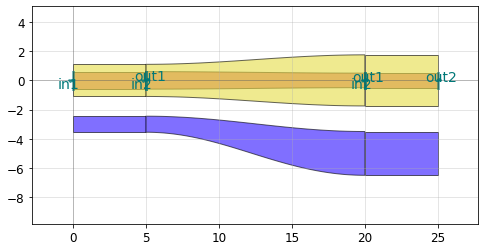

In [25]:
D = Device()
wg1 = D << WG1 # First cross-section Device
wg2 = D << WG2
wgt = D << WG_trans

wgt.connect('in2', wg1.ports['out1'])
wg2.connect('in2', wgt.ports['out1'])

qp(D)

Note that since `transition()` outputs a `CrossSection`, we can make the transition follow an arbitrary path:

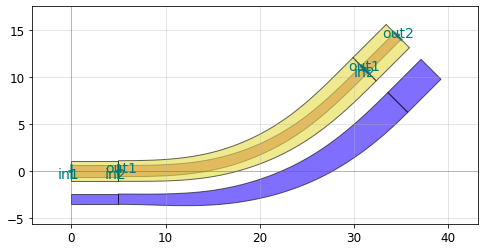

In [26]:
# Transition along a curving Path
P4 = pp.euler(radius = 25, angle = 45, p = 0.5, use_eff = False)
WG_trans = P4.extrude(Xtrans)

D = Device()
wg1 = D << WG1 # First cross-section Device
wg2 = D << WG2
wgt = D << WG_trans

wgt.connect('in2', wg1.ports['out1'])
wg2.connect('in2', wgt.ports['out1'])

qp(D)

## Variable width / offset

In some instances, you may want to vary the width or offset of the path's cross-section as it travels.  This can be accomplished by giving the `CrossSection` arguments that are functions or lists.  Let's say we wanted a width that varies sinusoidally along the length of the Path.  To do this, we need to make a width function that is parameterized from 0 to 1: for an example function  `my_width_fun(t)` where the width at `t==0` is the width at the beginning of the Path and the width at `t==1` is the width at the end.

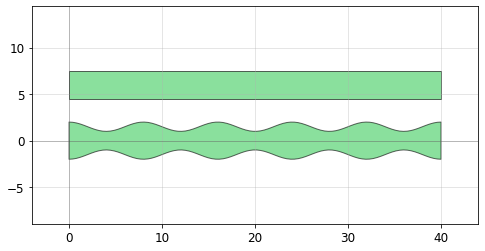

In [27]:
def my_custom_width_fun(t):
    # Note: Custom width/offset functions MUST be vectorizable--you must be able
    # to call them with an array input like my_custom_width_fun([0, 0.1, 0.2, 0.3, 0.4])
    num_periods = 5
    w =  3 + np.cos(2*np.pi*t * num_periods)
    return w

# Create the Path
P = pp.straight(length = 40)

# Create two cross-sections: one fixed width, one modulated by my_custom_offset_fun
X = CrossSection()
X.add(width = 3,                   offset = -6, layer = 0)
X.add(width = my_custom_width_fun, offset = 0,  layer = 0)

# Extrude the Path to create the Device
D = P.extrude(X)

qp(D)

We can do the same thing with the offset argument:

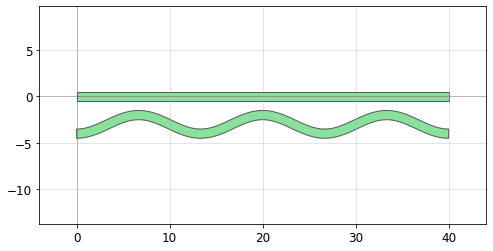

In [28]:
def my_custom_offset_fun(t):
    # Note: Custom width/offset functions MUST be vectorizable--you must be able
    # to call them with an array input like my_custom_offset_fun([0, 0.1, 0.2, 0.3, 0.4])
    num_periods = 3
    w =  3 + np.cos(2*np.pi*t * num_periods)
    return w

# Create the Path
P = pp.straight(length = 40)

# Create two cross-sections: one fixed offset, one modulated by my_custom_offset_fun
X = CrossSection()
X.add(width = 1, offset = my_custom_offset_fun, layer = 0)
X.add(width = 1, offset = 0, layer = 0)

# Extrude the Path to create the Device
D = P.extrude(X)

qp(D)

## Offsetting a Path

Sometimes it's convenient to start with a simple Path and offset the line it follows to suit your needs (without using a custom-offset CrossSection).  Here, we start with two copies of  simple straight Path and use the `offset()` function to directly modify each Path.

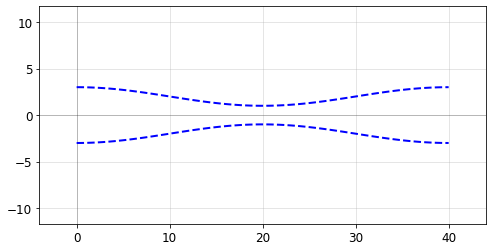

In [29]:
def my_custom_offset_fun(t):
    # Note: Custom width/offset functions MUST be vectorizable--you must be able
    # to call them with an array input like my_custom_offset_fun([0, 0.1, 0.2, 0.3, 0.4])
    num_periods = 1
    w =  2 + np.cos(2*np.pi*t * num_periods)
    return w


P1 = pp.straight(length = 40)
P2 = P1.copy() # Make a copy of the Path

P1.offset(offset = my_custom_offset_fun)
P2.offset(offset = my_custom_offset_fun)
P2.mirror((1,0)) # reflect across X-axis

qp([P1, P2])

## Modifying a CrossSection

In case you need to modify the CrossSection, it can be done simply by specifying a `name` argument for the cross-sectional element you want to modify later.  Here is an example where we name one of thee cross-sectional elements `'myelement1'` and `'myelement2'`:

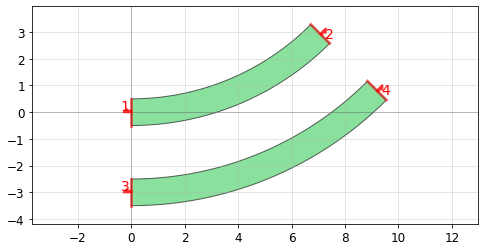

In [30]:
# Create the Path
P = pp.arc(radius = 10, angle = 45)

# Create two cross-sections: one fixed width, one modulated by my_custom_offset_fun
X = CrossSection()
X.add(width = 1, offset = 0, layer = 0, ports = (1,2), name = 'myelement1')
X.add(width = 1, offset = 3, layer = 0, ports = (3,4), name = 'myelement2')

# Extrude the Path to create the Device
D = P.extrude(X)

qp(D)

In case we want to change any of the CrossSection elements, we simply access the Python dictionary that specifies that element and modify the values

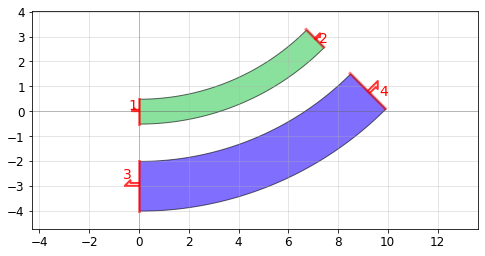

In [31]:
# Copy our original CrossSection
Xcopy = X.copy()

# Modify 
Xcopy['myelement2']['width'] = 2 # X['myelement2'] is a dictionary
Xcopy['myelement2']['layer'] = 1 # X['myelement2'] is a dictionary

# Extrude the Path to create the Device
D = P.extrude(Xcopy)

qp(D)